# Interpolating along a section
In this example we demonstrate how to create a gridded field from data on a section, for instance a set of profiles.

In [6]:
using DIVAnd
using DelimitedFiles
using Makie, CairoMakie
using Interpolations
using Statistics
using JupyterFormatter
enable_autoformat()
include("../config.jl")

"https://dox.uliege.be/index.php/s/qJtEotmkCZVqcx8/download"

## Files and directories

In [7]:
sectionfile = joinpath(datadir, "temp_seasoar_section_5.dat")
sectionfile_URL = make_dox_url("UmvV8JsQt3eS6PO")
datafile = sectionfile
download_check(sectionfile, sectionfile_URL)

[ Info: File already downloaded


## Read and plot data 

In [42]:
data = readdlm(datafile)
lat = data[:, 1]
depth = data[:, 2]
T = data[:, 3];
lon = -11.5 * ones(length(lat))

27251-element Vector{Float64}:
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
   ⋮
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5
 -11.5

### Plot temperature section

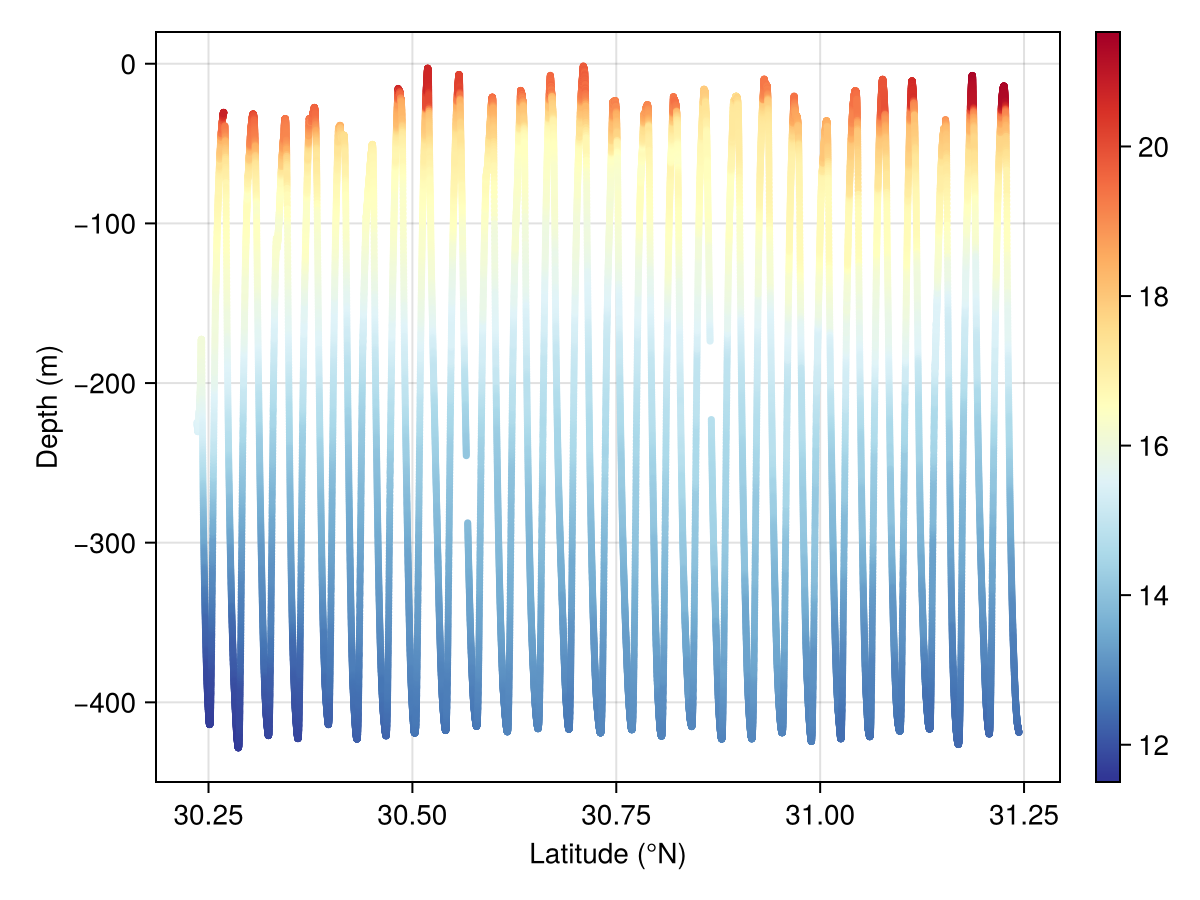

In [43]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Latitude (°N)", ylabel = "Depth (m)")
scat = scatter!(ax, lat, depth, markersize = 5, color = T, colormap = Reverse(:RdYlBu))
cb = Colorbar(fig[1, 2], scat)
fig

## Extract and plot bathymetry
Its resolution is chosen according to the extension of the region of interest.

In [44]:
bathname = gebco04file
download_check(gebco04file, gebco04fileURL)

[ Info: File already downloaded


We create a 2D grid for the bathymetry extraction: the goal is to know the bathymetry where we have the profiles, hence the original bathymetry has to be re-interpolated.

In [48]:
lonmin, lonmax, latmin, latmax = minimum(lon), maximum(lon), minimum(lat), maximum(lat)
Δlon = 0.1#, lonmax - lonmin;
Δlat = latmax - latmin;
xi = lonmin-0.05*Δlon:0.01:lonmax+0.05*Δlon
yi = latmin-0.05*Δlat:0.01:latmax+0.05*Δlat

bx, by, b = DIVAnd.extract_bath(bathname, true, xi, yi)

(-11.533333333342881:0.13333333333332575:-11.400000000009555, 30.06666666667263:0.13333333333333997:31.40000000000603, [2120.0 2175.39453125 … 2282.25390625 2462.10546875; 2086.6953125 2179.44921875 … 2065.375 2225.05859375])

In [49]:
lonmin, lonmax, latmin, latmax

(-11.5, -11.5, 30.236, 31.2437)

In [51]:
b

2×11 Matrix{Float64}:
 2120.0  2175.39  2270.46  2351.96  …  2894.87  2658.18  2282.25  2462.11
 2086.7  2179.45  2254.75  2344.37     2449.71  2317.45  2065.38  2225.06

Plot the bathymetry and the data locations.

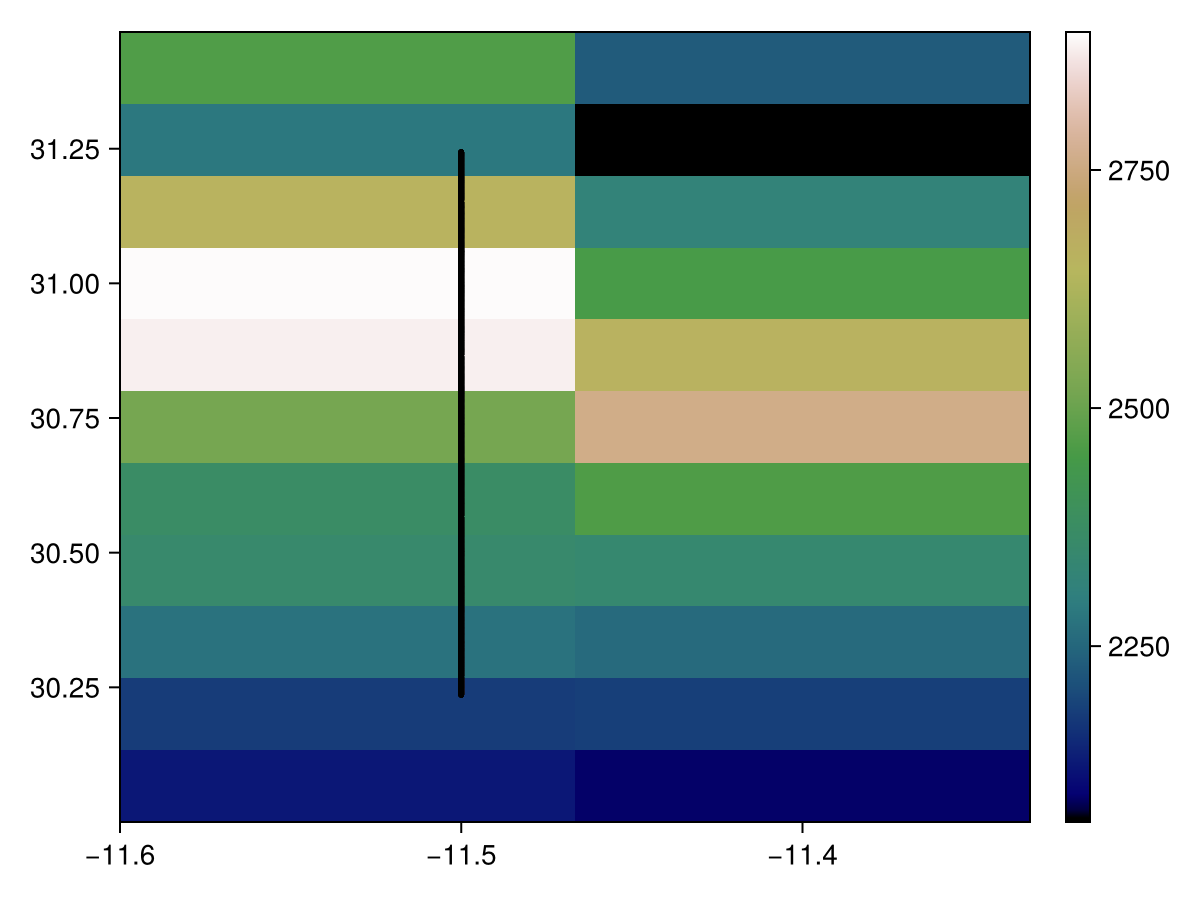

In [52]:
fig = Figure()
ax = Axis(fig[1, 1])
pcm = heatmap!(ax, bx, by, b, colormap = :gist_earth)
scatter!(ax, lon, lat, color = :black, markersize = 4)
Colorbar(fig[1, 2], pcm)
fig

### Create the interpolator

In [61]:
lon_u, lat_u = unique(lon), unique(lat)
itp = Interpolations.interpolate((bx, by), b, Gridded(Constant()));
depth_interp = itp.(lon_u, lat_u)

26793-element Vector{Float64}:
 2175.39453125
 2175.39453125
 2175.39453125
 2175.39453125
 2175.39453125
 2175.39453125
 2175.39453125
 2175.39453125
 2175.39453125
 2175.39453125
 2175.39453125
 2175.39453125
 2175.39453125
    ⋮
 2282.25390625
 2282.25390625
 2282.25390625
 2282.25390625
 2282.25390625
 2282.25390625
 2282.25390625
 2282.25390625
 2282.25390625
 2282.25390625
 2282.25390625
 2282.25390625

Plot the interpolated depth over the bathymetry to see if they correspond.

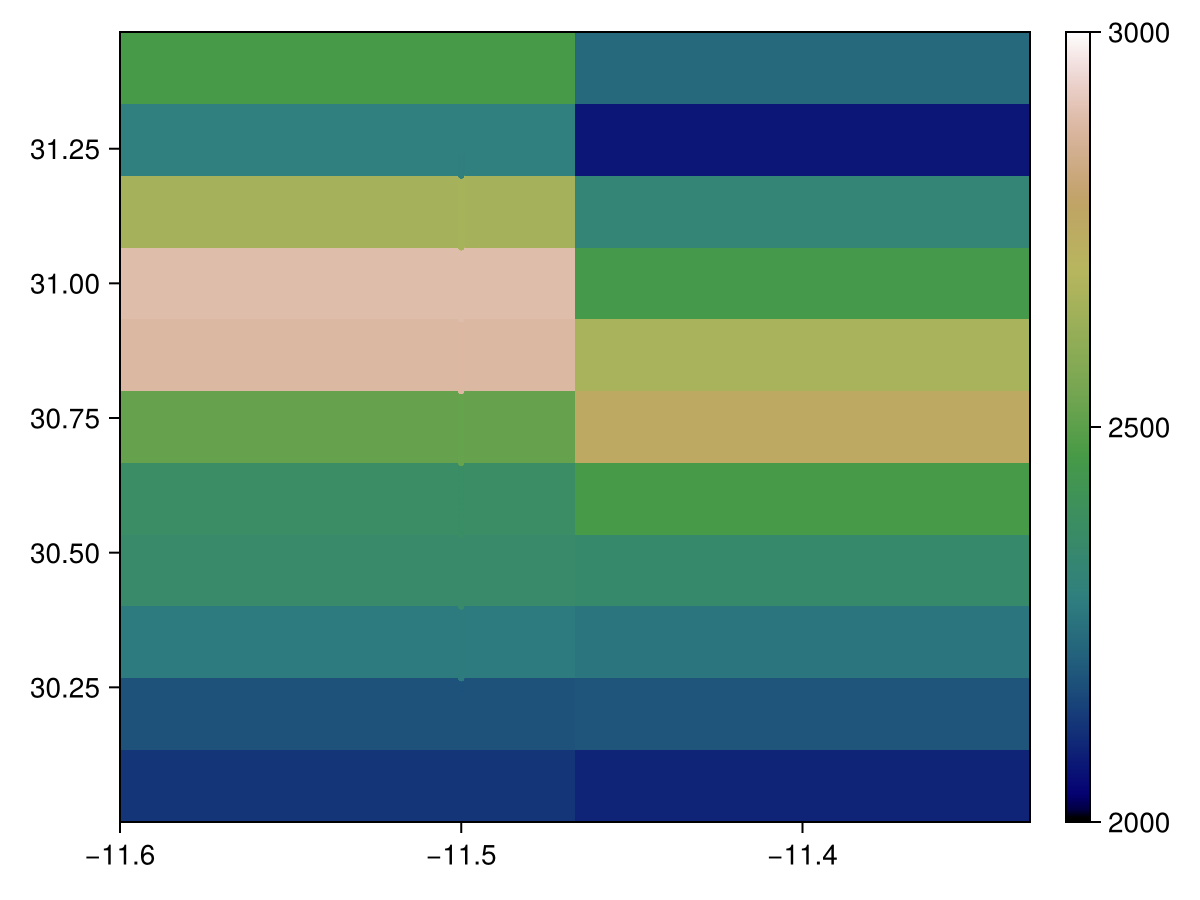

In [62]:
fig = Figure()
ax = Axis(fig[1, 1])
pcm = heatmap!(ax, bx, by, b, colormap = :gist_earth, colorrange = [2000.0, 3000.0])
scatter!(
    ax,
    lon_u,
    lat_u,
    color = depth_interp,
    markersize = 4,
    colormap = :gist_earth,
    colorrange = [2000.0, 3000.0],
)
Colorbar(fig[1, 2], pcm)
fig

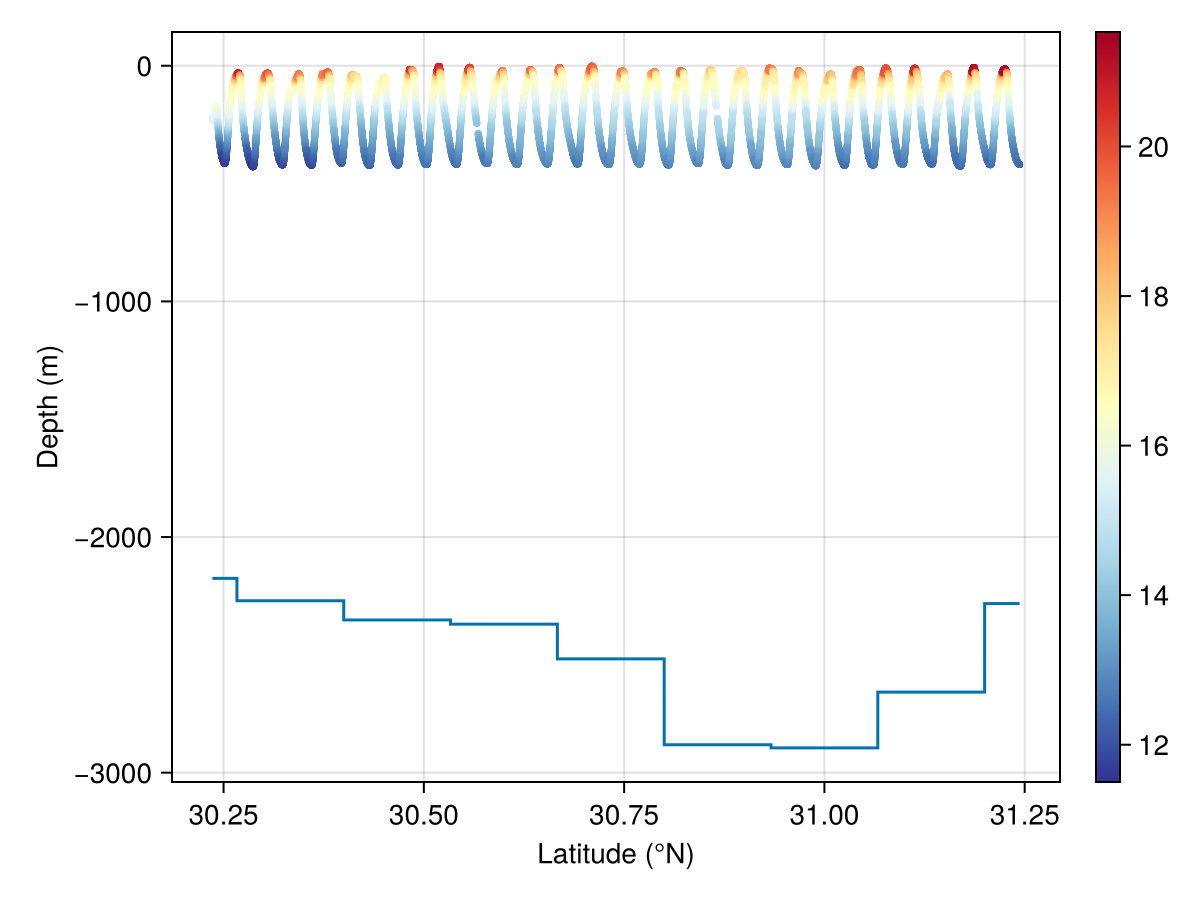

In [66]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Latitude (°N)", ylabel = "Depth (m)")
scat = scatter!(ax, lat, depth, markersize = 5, color = T, colormap = Reverse(:RdYlBu))
cb = Colorbar(fig[1, 2], scat)
lines!(ax, unique(lat), -depth_interp)
fig

## Create interpolation grid

In [83]:
Δlatg = 0.02 # degrees North
Δdepth = 1.0 # meter
latgrid = collect(minimum(lat):Δlatg:ceil(maximum(lat)))
depthgrid = collect(0.0:Δdepth:ceil(maximum(-depth)));

### Land sea mask
First we interpolate the bathymetry on the distance grid.

In [84]:
npoints = length(latgrid)
lon_grid = range(lon[1] - 0.05 * Δlon, lon[end] + 0.05 * Δlon; length = npoints);
lat_grid = range(lat[1], lat[end]; length = npoints)
depth_interp_grid = itp.(lon_grid, lat_grid);

Then we can construct the mask.

In [85]:
mask = falses(length(lat_grid), length(depthgrid));
for (ii, d) in enumerate(lat_grid)
    for (jj, h) in enumerate(depthgrid)
        if h < depth_interp_grid[ii]
            mask[ii, jj] = true
        end
    end
end;

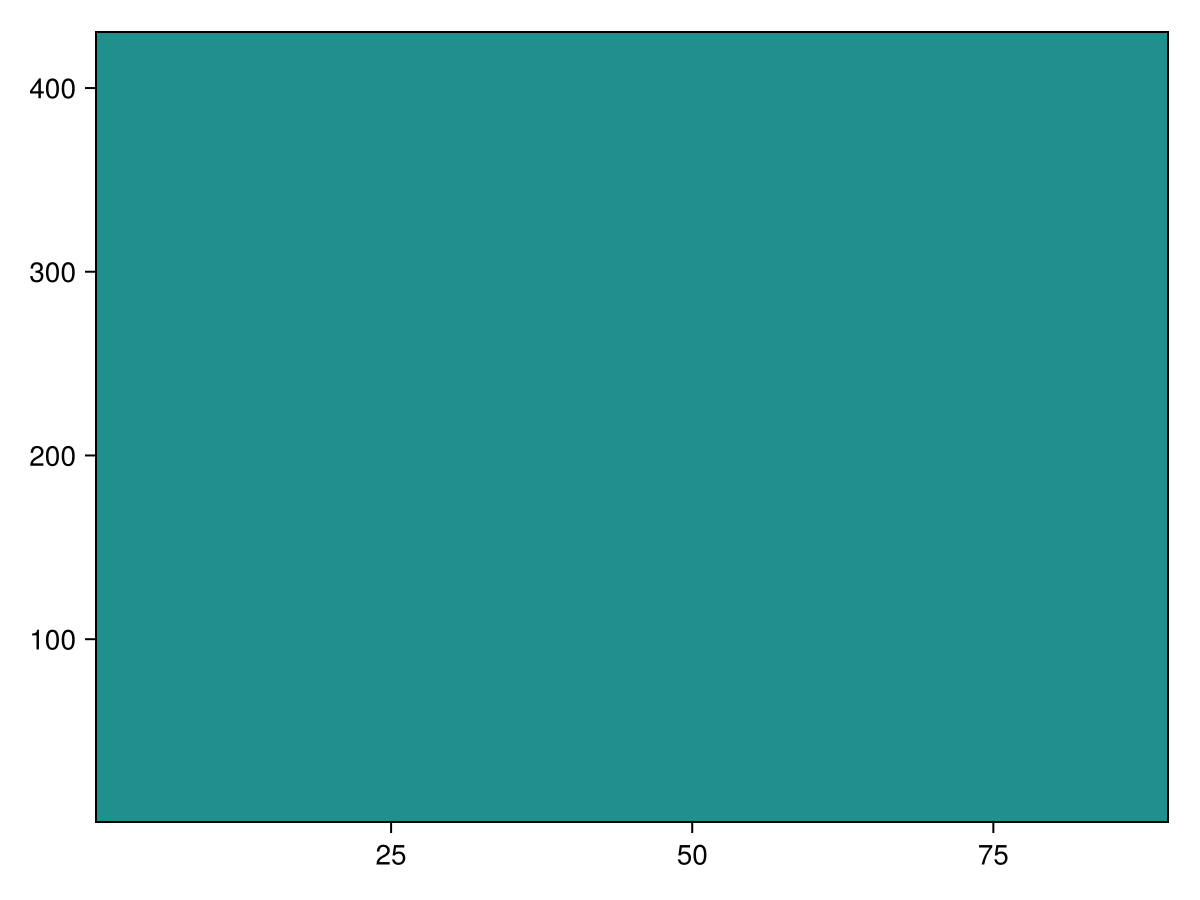

In [88]:
heatmap(mask)

## Analysis
### Create metrics

In [36]:
mask_rect, pmn, xyi = DIVAnd_rectdom(distgrid, depthgrid);

### Set parameters

In [37]:
len = (15.0 .* ones(length(distgrid), length(depthgrid)), 
        5.0 .* ones(length(distgrid), length(depthgrid))) # km, meters
epsilon2 = 5.

5.0

### Run analysis
We remove the mean value to get the anomalies.
#### Salinity

In [38]:
Sinterp, S_struct = DIVAndrun(mask_rect, pmn, xyi, (dist, pres), S .- mean(S), 
    len, epsilon2, alphabc=0);

In [ ]:
Smin, Smax = 34.3, 35.
PyPlot.pcolormesh(distgrid, depthgrid, Sinterp' .+ mean(S), 
    vmin=Smin, vmax=Smax, cmap=PyPlot.cm.RdYlBu_r)
PyPlot.scatter(dist, pres, s=1, c=S, 
    vmin=Smin, vmax=Smax, cmap=PyPlot.cm.RdYlBu_r)
xlabel("Distance (km)")
ylabel("Pressure (db)", rotation=0, ha="right")
PyPlot.colorbar()
PyPlot.gca().invert_yaxis()